# Analyse Textuelle

## Introduction

### Explorer les textes à l'aide du modèle d'espace vectoriel

Ce notebook explore la possibilité d'appliquer un raisonnement spatial aux données textuelles, en se demandant si l'on peut considérer les textes comme de simples points dans un espace, ayant des coordonnées exactes permettant de calculer la distance qui les sépare. L'idée est d'utiliser un modèle de vecteurs pour représenter les caractéristiques individuelles des textes, les transformant ainsi en nombres concrets nécessaires au traitement ultérieur. 

La première partie de ce notebook se concentre sur les étapes de prétraitement des données et la conversion d'un corpus en une représentation sac de mots. La deuxième partie présente une étude de cas sur les textes romanesques, utilisant le modèle de vecteurs et explorant les différences entre les sous-genres.

```
Exemple de représentation dans un espace vectoriel avec quatre documents (lignes) et un vocabulaire de quatre mots (colonnes). Pour chaque document, le tableau répertorie la fréquence de chaque élément du vocabulaire.

|          | _roi_ | _ange_ | _sang_ | _perdu_ |
|----------|-------|--------|--------|---------|
| $text_1$ |     1 |      2 |     16 |      21 |
| $text_2$ |     2 |      2 |     18 |      19 |
| $text_3$ |    35 |     41 |      0 |       2 |
| $text_4$ |    39 |     55 |      1 |       0 |
```

Dans ce tableau, chaque document $text_i$ est représenté sous forme de vecteur, qui est essentiellement une liste de nombres - les fréquences des mots dans notre cas présent. Un <span class="index">espace vectoriel</span> n'est rien de plus qu'une collection de vecteurs numériques, pouvant par exemple être additionnés et multipliés par un nombre. Les documents représentés de cette manière peuvent être comparés en termes de leurs *coordonnées* (ou *composantes*). Par exemple, en comparant les quatre documents sur la base de la deuxième coordonnée, nous observons que les deux premiers documents ($text_1$ et $text_2$) ont des comptes similaires, ce qui pourrait indiquer une certaine similarité entre ces deux documents. Pour obtenir une image plus précise et complète de la similarité des documents, nous aimerions pouvoir les comparer de manière plus holistique, en utilisant *toutes* leurs composantes. Dans notre exemple, chaque document représente un point dans un espace vectoriel à quatre dimensions. Nous pourrions hypothétiser que des documents similaires utilisent des mots similaires et résident donc à proximité les uns des autres dans cet espace. Pour illustrer cela, nous montrons comment visualiser les documents dans l'espace en utilisant les première et troisième composantes.```

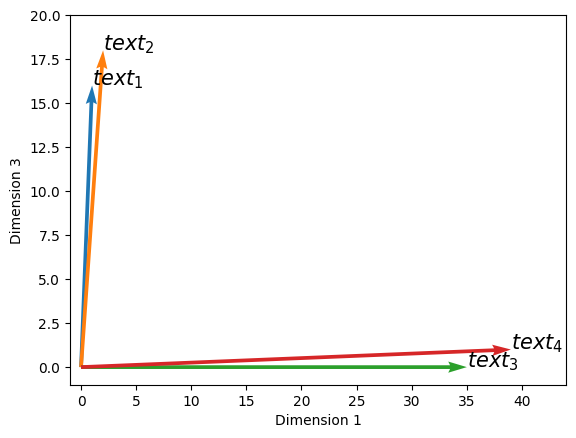

In [1]:
import numpy as np
import matplotlib.pyplot as plt

document_term_matrix = np.array([[1, 16], [2, 18], [35, 0], [39, 1]])
labels = '$text_1$', '$text_2$', '$text_3$', '$text_4$'
fig, ax = plt.subplots()
plt.quiver([0, 0, 0, 0], [0, 0, 0, 0],
           document_term_matrix[:, 0], document_term_matrix[:, 1],
           color=["C0", "C1", "C2", "C3"], angles='xy', scale_units='xy', scale=1)
for i, label in enumerate(labels):
    plt.annotate(label, xy=document_term_matrix[i], fontsize=15)
plt.ylim(-1, 20); plt.xlim(-1, 44)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 3");

Démonstration de quatre documents (représentés sous forme de vecteurs) résidant dans un espace bidimensionnel.

Ayant une compréhension théorique de base du modèle d'espace vectoriel, passons à la partie pratique de la mise en œuvre d'une procédure pour construire une <span class="index">matrice terme-document</span> à partir de texte brut. En essence, cela implique trois étapes: Déterminer le vocabulaire de ducorpus, en filtrant éventuellement les mots outils et la pionctuation. La deuxième étape consiste à compter combien de fois chaque élément du vocabulaire apparaît dans chaque document individuel. La troisième et dernière étape prend les sacs de mots de la deuxième étape et construit une matrice terme-document.

![steps bow](./data/bow.png)

### Prétraitement du texte

Une façon courante de représenter des documents textuels est d'utiliser des chaînes de caractères (associées au type `str` de Python). Considérons le bloc de code suivant, qui représente les dix mini-documents de la figure ci-dessus sous forme d'une liste de chaînes de caractères.

In [3]:
corpus = ["Cette histoire n’est pas fantastique, elle n’est que romanesque.",
          "L’étrange voyage ! Il avait si bien commencé cependant ! Pour ma part, je n’en fis jamais qui s’annonçât sous de plus heureux auspices.",
          "Le vieux baron des Ravots avait été pendant quarante ans le roi des chasseurs de sa province.",
          "La petite ville de Verrières peut passer pour l’une des plus jolies de la Franche-Comté.",
          "Sédentaire par devoir, tu crois, mon cher François, qu’emporté par le fier et capricieux dada de l’indépendance, je n’ai pas connu de plus ardent plaisir en ce monde que celui de traverser mers et montagnes, lacs et vallées.",
          "Que votre nom, vous dont le portrait est le plus bel ornement de cet ouvrage, soit ici comme une branche de buis bénit, prise on ne sait à quel arbre, mais certainement sanctifiée par la religion et renouvelée, toujours verte, par des mains pieuses, pour protéger la maison.",
          '– Et pourquoi cesserais-je d’être de mon village ? Il n’y faut pas compter. Te voilà bien fière, mon pauvre Minet-Chéri, parce que tu habites Paris depuis ton mariage.']

In [5]:
corpus[0].split()

['Cette',
 'histoire',
 'n’est',
 'pas',
 'fantastique,',
 'elle',
 'n’est',
 'que',
 'romanesque.']

Afin de construire une représentation *sac de mots* de chaque "texte" dans ce corpus, nous devons d'abord traiter les chaînes de caractères en mots distincts. Ce processus est appelé *tokenization* ou *segmentation de mots*. Un tokenizer naïf pourrait diviser les documents le long des espaces (contigus). En Python, un tel tokenizer peut être implémenté de manière simple en utilisant la méthode de chaîne `split()`. Comme le montre le bloc de code suivant, cette méthode utilise une stratégie de tokenization dans laquelle les tokens sont séparés par une ou plusieurs occurrences d'espaces (par exemple, des espaces, des tabulations, des sauts de ligne) :

In [6]:
document = corpus[6]
tokens = document.split()

In [7]:
tokens

['–',
 'Et',
 'pourquoi',
 'cesserais-je',
 'd’être',
 'de',
 'mon',
 'village',
 '?',
 'Il',
 'n’y',
 'faut',
 'pas',
 'compter.',
 'Te',
 'voilà',
 'bien',
 'fière,',
 'mon',
 'pauvre',
 'Minet-Chéri,',
 'parce',
 'que',
 'tu',
 'habites',
 'Paris',
 'depuis',
 'ton',
 'mariage.']

### Créer une matrice terme-document:

In [11]:
liste = ['liste', 'de', 'mots', 'longs', 'et', 'moinslongue', 10, 16, 'hgdzhgdhzgdzhgdzhdghz', 'de', 'mots']

In [12]:
collections.Counter(liste)

Counter({'de': 2,
         'mots': 2,
         'liste': 1,
         'longs': 1,
         'et': 1,
         'moinslongue': 1,
         10: 1,
         16: 1,
         'hgdzhgdhzgdzhgdzhdghz': 1})

In [13]:
import collections

vocabulary = collections.Counter()

for document in corpus:
    vocabulary.update(document.split())

`Counter` implémente plusieurs méthodes spécialisées pour des comptages pratiques et rapides. Par exemple, la méthode <span class="index">`Counter.most_common`</span> renvoie les *n* éléments les plus fréquents :

In [19]:
print(vocabulary.most_common(5))

[('de', 10), ('plus', 4), ('des', 4), ('le', 4), ('par', 4)]


Comme on peut le constater, les mots les plus fréquents dans le vocabulaire sont des mots fonctionnels (ou "<span class="index">mots vides</span>" comme on les appelle couramment), tels que *le* (déterminant), *et* (conjonction), et *de* (préposition). Les mots situés dans les rangs inférieurs de la liste de fréquence sont généralement des <span class="index">mots de contenu</span> qui ont un sens plus spécifique que les mots fonctionnels. En utilisant l'objet `Counter` construit ci-dessus, il est facile de composer un vocabulaire qui ignore ces hapax :

In [20]:
print('Original vocabulary size:', len(vocabulary))
pruned_vocabulary = {token for token, count in vocabulary.items() if count > 1}
print(pruned_vocabulary)
print('Pruned vocabulary size:', len(pruned_vocabulary))

Original vocabulary size: 140
{'Il', 'de', 'avait', 'la', 'je', 'mon', '!', 'bien', 'n’est', 'tu', 'pour', 'pas', 'des', 'et', 'plus', 'que', 'par', 'le'}
Pruned vocabulary size: 18


Pour rafraîchir votre mémoire, un ensemble Python <span class="index">`set`</span> est une structure de données bien adaptée pour représenter un vocabulaire. Un ensemble Python, à l'instar de son homologue en mathématiques, est une séquence non ordonnée d'éléments distincts. Comme un ensemble enregistre uniquement des éléments distincts, nous sommes assurés que tous les mots qui y apparaissent sont uniques. De manière similaire, nous pourrions construire un vocabulaire qui exclut les *n* jetons les plus fréquents :

In [26]:
n = 30
print('Original vocabulary size:', len(vocabulary))
pruned_vocabulary = {token for token, _ in vocabulary.most_common()[n:]}
print('Pruned vocabulary size:', len(pruned_vocabulary))

Original vocabulary size: 140
Pruned vocabulary size: 110


Notez comment la taille du vocabulaire élagué peut effectivement être réduite de manière agressive en utilisant de simples seuils de fréquence. En abstrayant ces deux fonctions concrètes, nous pouvons maintenant implémenter une fonction <span class="index">`extract_vocabulary()`</span>, qui extrait un vocabulaire à partir d'un corpus tokenisé en fonction d'un comptage de fréquence minimum et maximum :

In [27]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
    """Extraire un vocabulaire à partir d'un corpus tokenisé.

    Arguments:
        tokenized_corpus (list): un corpus tokenisé, représenté par une liste
            de listes de chaînes.
        min_count (int, facultatif): le nombre minimum d'occurrences d'un élément
            du vocabulaire dans le corpus.
        max_count (int, facultatif): le nombre maximum d'occurrences d'un élément
            du vocabulaire dans le corpus. Par défaut, infini.

    Renvoie:
        list: Une liste ordonnée alphabétiquement de mots uniques dans le
            corpus, dont les fréquences respectent le nombre minimum et maximum
            spécifié.

    Exemples:
        >>> corpus = [['the', 'man', 'love', 'man', 'the'],
                      ['the', 'love', 'book', 'wise', 'drama'],
                      ['a', 'story', 'book', 'drama']]
        >>> extract_vocabulary(corpus, min_count=2)
        ['book', 'drama', 'love', 'man', 'the']


    """
    vocabulary = collections.Counter()
    for document in tokenized_corpus:
        vocabulary.update(document)
    vocabulary = {word for word, count in vocabulary.items()
                  if count >= min_count and count <= max_count}
    return sorted(vocabulary)

Notez que le nombre maximum par défaut est défini sur l'infini (`max_count=float('inf')`). Cela garantit que aucun des mots à haute fréquence ne sera filtré sans spécification supplémentaire. La fonction peut être appelée comme suit :

In [30]:
tokenized_corpus = [document.split() for document in corpus]
vocabulary = extract_vocabulary(tokenized_corpus)

Une fois que le vocabulaire souhaité a été établi, nous sommes prêts à passer à la deuxième étape de la création d'une matrice terme-document. Rappelons que cette deuxième étape consiste à déterminer combien de fois chaque mot du vocabulaire apparaît dans chaque document. Il existe plusieurs façons de mettre cela en œuvre. Nous en illustrerons deux. Tout d'abord, nous représenterons le modèle d'espace vectoriel sous la forme d'une liste d'objets Counter, un pour chaque document. En utilisant une compréhension de liste, cela peut être facilement mis en œuvre comme suit :

In [32]:
bags_of_words = []
for document in tokenized_corpus:
    tokens = [word for word in document if word in vocabulary]
    bags_of_words.append(collections.Counter(tokens))

print(bags_of_words[0])

Counter({'n’est': 2, 'Cette': 1, 'histoire': 1, 'pas': 1, 'fantastique,': 1, 'elle': 1, 'que': 1, 'romanesque.': 1})


In [33]:
def corpus2dtm(tokenized_corpus, vocabulary):
    """Transformer un corpus tokenisé en une matrice terme-document.

    Arguments:
        tokenized_corpus (list): un corpus tokenisé sous la forme d'une liste de
        listes de chaînes. vocabulary (list): Une liste de mots uniques.

    Renvoie:
        list: Une liste de listes représentant la fréquence de chaque terme
              dans `vocabulary` pour chaque document du corpus.

    Exemples:
        >>> tokenized_corpus = [['the', 'man', 'man', 'smart'],
                                ['a', 'the', 'man' 'love'],
                                ['love', 'book', 'journey']]
        >>> vocab = ['book', 'journey', 'man', 'love']
        >>> corpus2dtm(tokenized_corpus, vocabulary)
        [[0, 0, 2, 0], [0, 0, 1, 1], [1, 1, 0, 1]]

    """
    document_term_matrix = []
    for document in tokenized_corpus:
        document_counts = collections.Counter(document)
        row = [document_counts[word] for word in vocabulary]
        document_term_matrix.append(row)
    return document_term_matrix




In [34]:
document_term_matrix = corpus2dtm(tokenized_corpus, vocabulary)

In [36]:
len(document_term_matrix)

7

La variable `document_term_matrix` contient maintenant une représentation tabulaire du corpus. Chaque ligne est associée à un document et chaque colonne est associée à un élément du vocabulaire. Le tableau ci-dessous montre les premières lignes et plusieurs colonnes de cette table.

In [39]:
import pandas as pd
df = pd.DataFrame(document_term_matrix, columns=vocabulary)

In [40]:
df

,!,?,Cette,Et,Franche-Comté.,"François,",Il,La,Le,L’étrange,...,vieux,village,ville,voilà,votre,vous,voyage,à,été,–
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
6,0,1,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1


Bien que la liste Python soit un type de données pratique pour la *construction* d'une matrice terme-document, elle est moins utile lorsque l'on souhaite accéder et manipuler la matrice. Dans ce qui suit, nous utiliserons le package Python standard pour le calcul scientifique, <span class="index">NumPy</span>, qui nous permet de stocker et d'analyser les matrices terme-document avec moins de ressources computationnelles et beaucoup moins d'efforts de notre part. Afin de ne pas perturber le fil narratif du chapitre, nous n'introduirons pas ce package en détail ici : les lecteurs moins expérimentés sont renvoyés à l'aperçu introductif à la fin de ce chapitre, qui discute en détail des principales fonctionnalités du package.

## Cartographie des Genres

#### Chargement du corpus


![genre du corpus chapitres](./data/genres_corpus.png)

#### Explorer the corpus

Après avoir chargé les romans en mémoire, nous pouvons transformer la collection en une <span class="index">matrice terme-document</span>. Dans le bloc de code suivant, nous prétraitons d'abord chaque pièce en utilisant la fonction `preprocess_text()` définie précédemment, qui renvoie une liste de jetons de mots en minuscules pour chaque pièce. Ensuite, nous construisons le <span class="index">vocabulaire</span> avec `extract_vocabulary()`, et <span class="index">élaguons</span> tous les mots qui apparaissent moins de deux fois dans la collection. La dernière étape consiste alors à assembler la matrice terme-document en calculant les comptes de jetons pour tous les mots restants dans le vocabulaire pour chaque document de la collection.

In [41]:
# get a list of str of the corpus
from glob import glob
path_txt = "corpus/*.txt"

In [42]:
corpus = []
for doc in glob(path_txt):
    print(doc)
    with open(doc, encoding="utf8") as file_in:
        text = file_in.read()
        corpus.append(text.replace('\xa0', ' '))

corpus/1902_Loti-Pierre_Les-derniers-jours-de-Pekin.txt
corpus/1906_Gide-Andre_Amyntas.txt
corpus/1933_Veuzit-Max-du_Vers-l'unique.txt
corpus/1938_Larbaud-Valery_Aux-couleurs-de-Rome.txt
corpus/1905_Farrere-Claude_Les-civilises.txt
corpus/1955_Delly_Ourida.txt
corpus/1904_Le-Rouge-Gustave_L-Esclave-amoureuse.txt
corpus/1913_Delly_Entre-deux-ames.txt
corpus/1912_Loti-Pierre_Un-pelerin-d-Angkor 2.txt
corpus/1908_Veuzit-Max-du_Le-mystere-de-Malbackt.txt
corpus/2008_Rolin-Olivier_La-Chambre-des-cartes.txt
corpus/1913_Delly_Dans-l'ombre-du-mystere.txt
corpus/1913_Dombre-Roger_Un-tuteur-embarrasse.txt
corpus/1903_Vogue-Eugene-Melchior-de_Le-Maitre-de-la-mer.txt
corpus/1902_Le-Rouge-Gustave_La-Princesse-des-airs_Tome-II.txt
corpus/1905_Lermina-Jules_To-Ho-Le-Tueur-d-or.txt
corpus/1905_Le-Rouge-Gustave_L-Espionne-du-grand-Lama.txt
corpus/1912_Loti-Pierre_Un-pelerin-d-Angkor.txt
corpus/1932_Veuzit-Max-du_Petite-comtesse.txt
corpus/1900_Verne-Jules-_Seconde-patrie.txt
corpus/1905_Verne-Jules_Le-

In [18]:
len(corpus)

37

In [46]:
len(corpus)

37

In [44]:
roman_tok = [roman.split() for roman in corpus]
vocabulary = extract_vocabulary(roman_tok, min_count=2)
document_term_matrix = np.array(corpus2dtm(roman_tok, vocabulary))

print(f"document-term matrix avec "
      f"|D| = {document_term_matrix.shape[0]} documents et "
      f"|V| = {document_term_matrix.shape[1]} mots.")

document-term matrix avec |D| = 37 documents et |V| = 68089 mots.


In [45]:
len(document_term_matrix[0])

68089

Nous sommes maintenant prêts à commencer notre analyse : nous avons une représentation efficace en sac de mots d'un corpus sous la forme d'une matrice NumPy (un tableau bidimensionnel) et une liste d'étiquettes qui code de manière non ambiguë le genre pour chaque vecteur de document dans cette table.

Commençons par représenter naïvement les documents disponibles, comme si les comptages de fréquence pour deux mots spécifiques dans notre modèle de sac de mots étaient simplement des coordonnées bidimensionnelles sur une carte. 

In [60]:
voyage_idx = vocabulary.index('capitale')
amour_idx = vocabulary.index('amour')

voyage_compte = document_term_matrix[:, voyage_idx]
amour_compte = document_term_matrix[:, amour_idx]

In [61]:
voyage_compte

array([2, 0, 2, 2, 3, 0, 1, 0, 1, 0, 2, 1, 1, 2, 6, 1, 0, 1, 1, 5, 1, 0,
       7, 0, 1, 1, 1, 1, 9, 7, 0, 2, 0, 0, 0, 0, 1])

Bien que NumPy soit optimisé pour traiter des données numériques, les listes de chaînes peuvent également être converties en tableaux (<span class="index">arrays</span>). C'est précisément ce que nous ferons également avec notre liste d'étiquettes de genre, afin de faciliter le processus de récupération des emplacements d'étiquettes de genre spécifiques dans la liste plus tard :

In [62]:
genres = np.array(['voyage', 'voyage', 'romance', 'voyage', 'aventure', "romance", 'aventure', 'romance', 'voyage', 'romance', 'voyage', 'romance', 'voyage', 'aventure', 'aventure', 'aventure', 'aventure', 'voyage', 'romance', 'aventure', 'aventure', 'romance', 'voyage', 'romance', 'aventure', 'aventure', 'voyage', 'aventure', 'voyage', 'voyage', 'romance', 'voyage', 'aventure', 'voyage', 'romance', 'romance', 'romance'])

Les vecteurs de colonne, `voyage_compte` et `amour_compte`, ont tous deux la même longueur et comprennent les comptages de fréquence pour chacun de nos deux mots dans chaque document. En utilisant les étiquettes dans la liste correspondante des tags de genre, nous pouvons maintenant représenter chaque document comme un point dans l'espace bidimensionnel défini par les deux vecteurs de comptage. Soyez attentif aux deux premiers arguments passés à la fonction `scatter()` à l'intérieur de la boucle `for` dans laquelle nous itérons sur les trois genres : en utilisant le mécanisme d'« <span class="index">indexation booléenne</span> », nous sélectionnons les comptages de fréquence pour les documents pertinents et nous les représentons comme un groupe à chaque itération. La figure ci-dessous est générée en utilisant le bloc de code suivant :

In [63]:
voyage_compte

array([2, 0, 2, 2, 3, 0, 1, 0, 1, 0, 2, 1, 1, 2, 6, 1, 0, 1, 1, 5, 1, 0,
       7, 0, 1, 1, 1, 1, 9, 7, 0, 2, 0, 0, 0, 0, 1])

In [64]:
amour_compte

array([ 0,  0,  9,  3, 11,  1,  1,  2,  0,  2,  0,  6,  0, 20,  0,  1,  0,
        0,  1,  1,  0, 13,  0,  9,  1,  0,  0,  0,  2,  0,  5,  0,  1,  6,
        4,  6,  1])

In [65]:
len(genres)

37

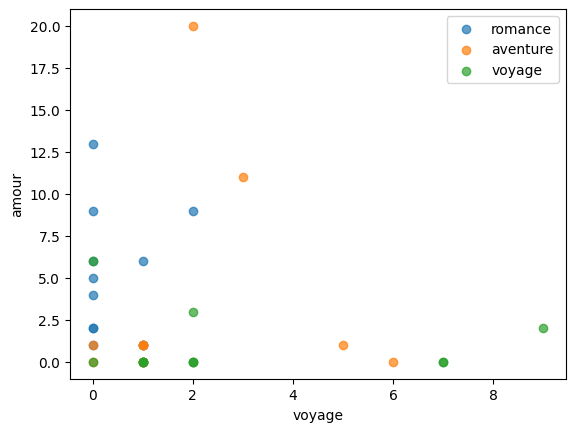

In [66]:
fig, ax = plt.subplots()

for genre in ('romance', 'aventure', 'voyage'):
    ax.scatter(voyage_compte[genres == genre],
               amour_compte[genres == genre],
               label=genre, alpha=0.7)

ax.set(xlabel='voyage', ylabel='amour')
plt.legend();



#### Sous-genre et Vecteurs

Comment pourrait-on vérifier ces impressions ?

In [67]:
romance_means = document_term_matrix[genres == 'romance'].mean(axis=0)
aventures_means = document_term_matrix[genres == 'aventure'].mean(axis=0)
voyage_means = document_term_matrix[genres == 'voyage'].mean(axis=0)

Les vecteurs moyens résultants contiendront une liste ou un vecteur unidimensionnel pour chaque terme de notre vocabulaire :

In [68]:
print(aventures_means.shape)

(68089,)


We still can use the precomputed indices to retrieve the mean frequency of individual words from these summary vectors:

In [69]:
print('Mean absolute frequency of "voyage"')
print(f'   in romance: {romance_means[voyage_idx]:.2f}')
print(f'   in aventures: {aventures_means[voyage_idx]:.2f}')
print(f'   in voyage: {voyage_means[voyage_idx]:.2f}')

Mean absolute frequency of "voyage"
   in romance: 0.42
   in aventures: 1.83
   in voyage: 2.69


The mean frequencies for these words are again revealing telling differences across our
three genres. This also becomes evident by plotting the mean values in a scatter plot:

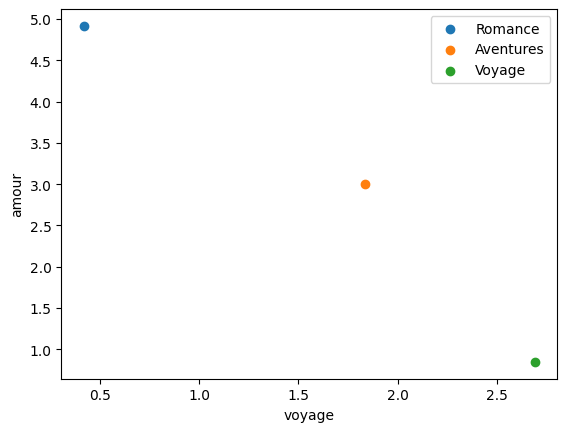

In [70]:
fig, ax = plt.subplots()

ax.scatter(
    romance_means[voyage_idx], romance_means[amour_idx], label='Romance')
ax.scatter(
    aventures_means[voyage_idx], aventures_means[amour_idx], label='Aventures')
ax.scatter(
    voyage_means[voyage_idx], voyage_means[amour_idx], label='Voyage')

ax.set(xlabel='voyage', ylabel='amour')
plt.legend();

## Autres Modèles vectoriels - en TAL -> tf-idf, embeddings (DBOW)..
le tal c'est aussi du NER, du sentiment analysis, ...